<a href="https://colab.research.google.com/github/rnayebi21/PolygenceMLResearch-scRNAseq/blob/main/Brain_Cell_GNB_PCA_%2B_Standard_Scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn import metrics
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set()

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
Pilocytic_Astrocytoma_Metadata_ID = "1Q2-7lvQVWQH6K7T23vCfHN6KKpdjyyuJ"
Brain_file = drive.CreateFile({'id':Pilocytic_Astrocytoma_Metadata_ID})
Brain_file.GetContentFile('metadata3_20181216.txt')
Brain_metadata = pd.read_csv("metadata3_20181216.txt", sep = "\t")


Brain_gene_expression_ID = "10KBUSNHD_0NmcX8KkLhiVgTyf5RXseY7"
Brain_GE_file = drive.CreateFile({'id':Brain_gene_expression_ID})
Brain_GE_file.GetContentFile('Pilocytic_astro.txt')
Brain_GE = pd.read_csv("Pilocytic_astro.txt", sep = "\t")


Brain_GE.index = Brain_GE["GENE"]
Brain_GE = Brain_GE.drop("GENE", axis = 1)
Brain_GE.index.name=""
Brain_GE = Brain_GE.transpose()
Brain_GE["cells"] = Brain_GE.index
future_ind = []
for i in range(0,942):
  future_ind.append(i)
Brain_GE.index = future_ind
Brain_GE = Brain_GE.sort_values(by="cells")
Brain_GE.index = Brain_GE["cells"]
Brain_GE.index.name=""
Brain_GE = Brain_GE.drop("cells", axis=1)


Brain_metadata = Brain_metadata.sort_values(by="NAME")
Brain_metadata.index = Brain_metadata.NAME
Brain_metadata = Brain_metadata.drop("NAME", axis = 1)
Brain_metadata.index.name = ""
Brain_metadata = Brain_metadata.drop("TYPE", axis= 0)

In [9]:
common_cells = []
for i in range(len(Brain_GE.index)):
  if Brain_GE.index[i] in Brain_metadata.index:
    common_cells.append(Brain_GE.index[i])

In [10]:
Brain_GE_copy = Brain_GE
for i in range(len(Brain_GE_copy.index)):
  if Brain_GE_copy.index[i] not in common_cells:
    Brain_GE = Brain_GE.drop(Brain_GE_copy.index[i], axis = 0)

In [14]:
Brain_labels = Brain_metadata["Cluster"]
labels_df = pd.DataFrame(Brain_labels)

In [16]:
scaler = StandardScaler()
scaler.fit(Brain_GE, Brain_labels)
Brain_GE_scaled = scaler.transform(Brain_GE)

In [17]:
x_train,x_test,train_lbls,test_lbls=train_test_split(Brain_GE_scaled,Brain_labels,test_size=0.3,random_state=0)

In [18]:
num_components = np.array([])
for i in range(1, 11):
  delta = (i/2)/10
  pca = PCA(1 - delta)
  pca.fit(x_train)
  num_components = np.append(pca.n_components_, num_components)
  print(*[i, ":", pca.n_components_])

1 : 471
2 : 371
3 : 296
4 : 238
5 : 191
6 : 153
7 : 124
8 : 102
9 : 85
10 : 71


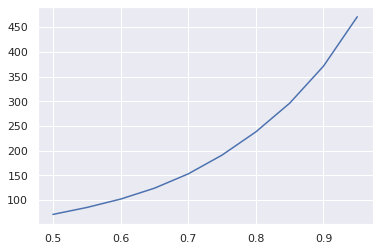

In [19]:
index_of_PCA =  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
plt.plot(index_of_PCA, num_components)

no elbow so we will use 85

In [20]:
pca = PCA(0.85)
pca.fit(Brain_GE_scaled)
Brain_GE_scaled_PCA = pca.transform(Brain_GE_scaled)

In [21]:
train_PCA, test_PCA, train_lbl_PCA, test_lbl_PCA = train_test_split(Brain_GE_scaled_PCA, labels_df, test_size = 0.3, random_state = 1)

In [27]:
def confusion_matrix_brain (lbl, pred):
  cm = metrics.confusion_matrix(lbl, pred)
  plt.figure(figsize=(11,11))
  plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
  plt.title('Confusion Matrix', size = 15)
  plt.colorbar()
  tick_marks = np.arange(5)
  plt.xticks(tick_marks, ['0', '1', '2', '3', '4'], rotation = 45, size = 10)
  plt.yticks(tick_marks, ['0', '1', '2', '3', '4'], size = 10)
  plt.tight_layout()
  plt.ylabel('Actual', size = 15)
  plt.xlabel('Predicted', size = 15)
  width, height = cm.shape

  for x in range(width):
    for y in range(height):
      plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

In [23]:
GNB_params_v_smoothing = {"var_smoothing": np.logspace(-64, -25, num=40)}
GNB_scaled = GaussianNB()
GNB_grid_search = GridSearchCV(GNB_scaled, GNB_params_v_smoothing, cv = 5)

In [24]:
GNB_grid_search.fit(train_PCA, train_lbl_PCA)
GNB_grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

{'var_smoothing': 1e-64}

In [25]:
best_GNB_model = GNB_grid_search.best_estimator_
best_GNB_model_pred = best_GNB_model.predict(test_PCA)
best_GNB_model.score(test_PCA, test_lbl_PCA)

0.45

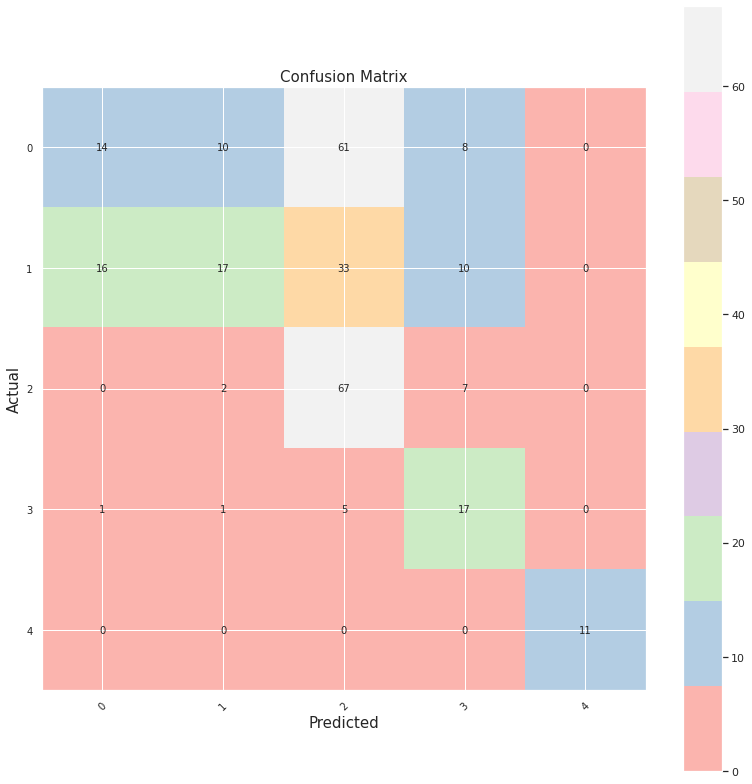

In [28]:
confusion_matrix_brain(test_lbl_PCA, best_GNB_model_pred)

unlike the other two datasets, scaling the data caused a worse performance